# CHSH inequality

Once again, as we continue our exploration of basic quantum computing experiments and practices, this time we tackle the CHSH inequality, following IBM's wonderful tutorial here: https://quantum.cloud.ibm.com/docs/en/tutorials/chsh-inequality

But I'll be diving a few layers deeper to provide a more balanced and simpler explanation of what the hell is going on?


#### What is the CHSH inequality?

Firstly, CHSH is simply the authors: Clauser, Horne, Shimony, and Holt. The CHSH inequality is a mathematical expression used to test whether the predictions of quantum mechanics:

Which predicts that the CHSH inequality can be violated, with a maximum value of 
$$
2\sqrt{2} \approx 2.828
$$

It tests whether this can actually be explained by any local hidden variable theory, is so we shouldn't get a value larger than 2.

Local hidden variable theory is a classical idea that tries to explain quantum phenomena using two assumptions:
- Locality: No information or influence travels faster than light. What happens to one particle cannot instantly affect another far away.
- Realism: Particles have pre-existing properties (hidden variables) that determine the outcomes of measurements, even if we don’t know them.

In this view, the strange correlations seen in quantum experiments are just the result of these hidden variables — not spooky action at a distance. 👻

#### Bell's theorem

Bell’s Theorem, formulated by physicist John Stewart Bell in 1964, addresses a fundamental question raised by Einstein, Podolsky, and Rosen (EPR) in 1935: Is quantum mechanics a complete theory, or are there “hidden variables” that determine outcomes behind the scenes?

Bell showed that if such hidden variables exist and if they obey locality (no faster-than-light influence), then the correlations between entangled particles must obey certain mathematical limits — now known as Bell inequalities.

#### To summarise

I'm not sure I fully understand this, but in essence we are looking to see whether we will get a value larger than 2 from this inequality. If that is the case, then nature does work quantum mechanically and cannot be explained by local variable hidden theory.



## Step 1. Mapping the Problem, and creating the circuit

To perform this experiment requires the entanglement of a pair of qubits on two different bases. The first qubit will have bases of A and a, and the second will have B and b.  This can be expressed as the **quantity**:

$$
S_1 = A(B - b) + a(B + b)
$$

### What are the bases?

The bases here refer to the different directions that you choose to measure the qubit. In this experiment, we measure one qubit in the Z and X bases,different also orthogonal angles $ \theta $. Note we will sweep the angle between 0 and 2 $\pi$ to show the inequality rising and falling above and below 2. Cool right?

So if we know that the result of the measuring the observable must only be either 1 or -1 (since the measurement projects the qubit into one of two states either be up or down along that measurement axis). 

Therefore, for any possible value of B or b. The outcome will either be 0 or 2. 

Suppose B and b are both +1 or both -1:

B + b = +2 or -2
B - b = 0
Suppose B and b are different (+1 and -1 or -1 and +1):

B + b = 0
B - b = +2 or -2

This means the average value of $ S_1 $ must be less than 2.

$$
|\langle S_1 \rangle| \leq 2
$$

This eventually leads to the following **inequality**:
$$
|\langle S_1 \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2
$$

An alternative **quanitity** is:

$$
S_2 = A(B + b) - a(B - b)
$$

This leads to the inequality

$$
|\langle S_2 \rangle| = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle| \leq 2
$$


In [ ]:
import sys
sys.path.append('../..')
from qiskit_service import service

backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

backend.name


'ibm_fez'

## Step 1: Preparing the Ciruit

We need to firstly create a circuit that turns both of qubits into an entangled state using a Hadamard Gate followed by a CNOT (with the first qubit as control and the second as target), you then apply measurement basis rotations to each qubit depending on which observable (A, a, B, b) you want to measure 📏. 

To begin, we will set up an entangled state, and apply a theta rotation to one of the qubits. 

`chsh_circuit.ry(theta, 0)` applies a parametised rotation around the Y-axis (Ry gate) by an angle theta to qubit 1.

We will then use the Estimator primitive to measure the expectation value of the observable (more on observable selection soon).

#### What is a parametised rotation?

A parameterized rotation is a quantum gate that rotates a qubit by an angle 📐 specified by a variable (parameter), rather than a fixed value. This allows you to change the rotation angle without rebuilding the circuit—just by assigning a new value to the parameter. 

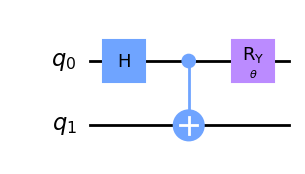

In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

theta = Parameter("$\\theta$")
 
chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw(output="mpl", idle_wires=False, style="clifford")

### Setting up the parameterized rotation phases

We will set up a list of 21 phase values e.g. theta parameters from 0 to $2pi$, also known as $360^\circ$.

In [8]:
import numpy as np
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]
print(individual_phases)

[[np.float64(0.0)], [np.float64(0.3141592653589793)], [np.float64(0.6283185307179586)], [np.float64(0.9424777960769379)], [np.float64(1.2566370614359172)], [np.float64(1.5707963267948966)], [np.float64(1.8849555921538759)], [np.float64(2.199114857512855)], [np.float64(2.5132741228718345)], [np.float64(2.827433388230814)], [np.float64(3.141592653589793)], [np.float64(3.4557519189487724)], [np.float64(3.7699111843077517)], [np.float64(4.084070449666731)], [np.float64(4.39822971502571)], [np.float64(4.71238898038469)], [np.float64(5.026548245743669)], [np.float64(5.340707511102648)], [np.float64(5.654866776461628)], [np.float64(5.969026041820607)], [np.float64(6.283185307179586)]]


### Setting up the observables

As we have discussed before, we need observables to measure the expectation value of. Since we are changing Y, we need to look at the orthogonal angles, e.g. X and Z. These are the measurement basis. Remember when we are talking about AB or Ab, they will equate to ZZ & ZX.

The second inequality looks the same, but has a negative (-) coeffcient.

In [11]:
from qiskit.quantum_info import SparsePauliOp

# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)]
)
 
# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)]
)

print(observable1)
print(observable2)

SparsePauliOp(['ZZ', 'ZX', 'XZ', 'XX'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j])
SparsePauliOp(['ZZ', 'ZX', 'XZ', 'XX'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j,  1.+0.j])


## Step 2: Heading back to quantum reality

As discussed before Quantum Hardware today is a bit sh*t, so we need to turn our beautiful circuit into something that can be executed by Mr Fez (the Backend). 

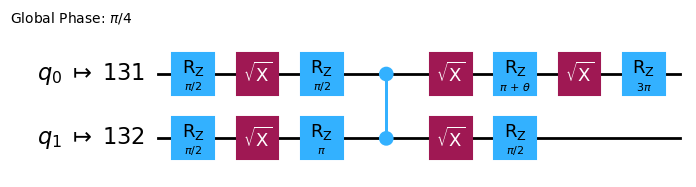

In [ ]:
from qiskit import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
 
chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="clifford")

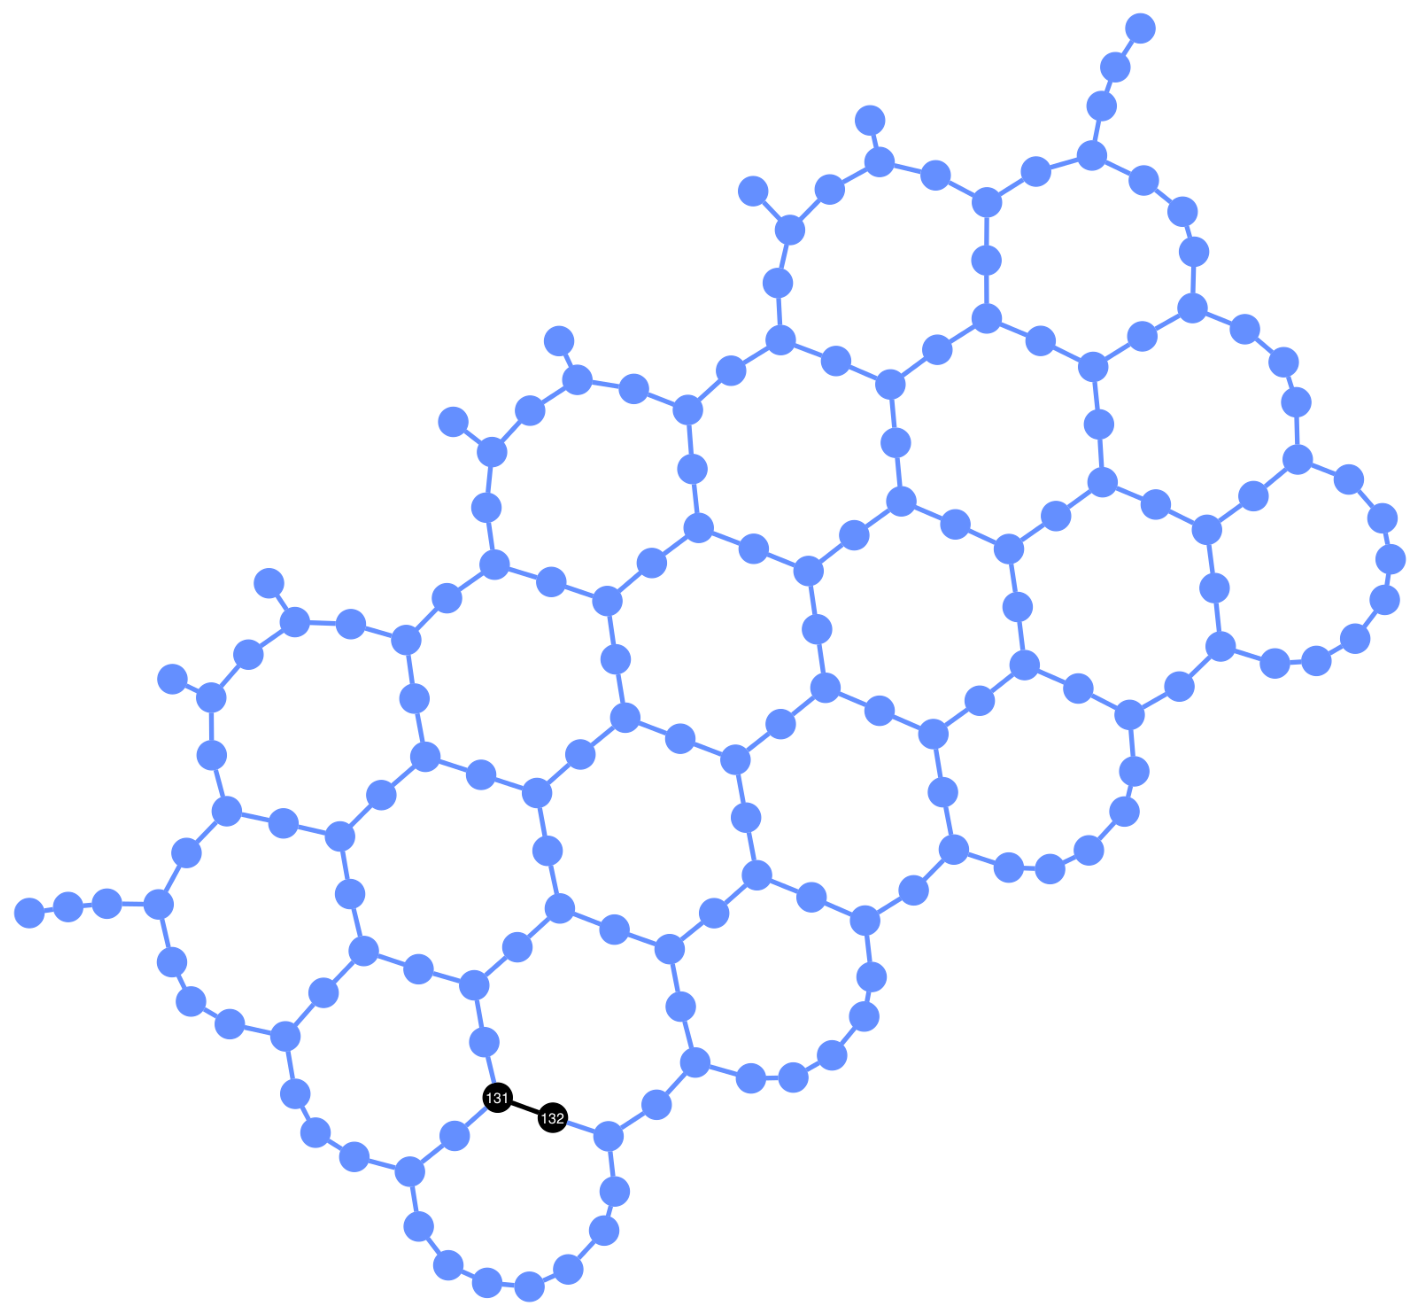

In [19]:

from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(chsh_isa_circuit, backend, view='physical')

We also need to make the observables backend compatible using apply_layout. What we have done here is aligned the observables to the qubits that the generate pass manager has chosen as the physical qubits (lucky qubits 131 and 132) 

In [16]:
isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)
print(isa_observable1)
print(isa_observable2)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIXZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIXXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j])
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZXIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 3. Executing this bad boy

The EstimatorV2.run() method takes an iterable of primitive unified blocs (PUBs). Each PUB is an iterable in the format (circuit, observables, parameter_values: Optional, precision: Optional).

Since we pass `[[isa_observable1], [isa_observable2]]`, the first run will use the first set, the second will use the second.

We also pass the phases, so the Estimator knows what values to use for the rotations of each circuit execution. For this job we expect, 2 x 21 = 42 runs... an expensive run indeed. That's 20% of my credit balance 🚀

In [21]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(mode=backend)
 
pub = (
    chsh_isa_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    individual_phases,  # Parameter values
)
 
job_result = estimator.run(pubs=[pub])

print(job_result.job_id())

d44p7fgoftds73c7mb20


In [29]:
usage = service.job("d44p7fgoftds73c7mb20").usage()
print(usage)

status = service.job("d44p7fgoftds73c7mb20").status()
print(status)

properties = service.job("d44p7fgoftds73c7mb20").properties()
print(properties)

results = service.job("d44p7fgoftds73c7mb20").result()
print(results)

127
DONE
PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(2, 21), dtype=float64>), stds=np.ndarray(<shape=(2, 21), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(2, 21), dtype=float64>), shape=(2, 21)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})
